In [3]:
import os
import numpy as np
import pandas as pd
import librosa, librosa.display
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
from tqdm import tqdm_notebook as tqdm

In [4]:
train_dirname = './TUT-acoustic-scenes-2016-development'
test_dirname = './TUT-acoustic-scenes-2016-evaluation'

In [5]:
# load a wave data
def load_wave_data(file_path, fs=22050):
    x, fs = librosa.load(file_path, sr=fs)
    return x, fs

def chunked(data, n):
    return [data[x:x + n] for x in range(0, len(data), n)]

# calculate mel-spectrogram
def calc_melsp(x, sr=22050, n_fft=2048, hop_length=512, n_mels=128, fmax=8000):
    S = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)
    melsp = librosa.power_to_db(S, ref=np.max)
    return melsp

# show wave
def plot_wave(x):
    print('wave size: {0}'.format(x.shape))
    librosa.display.waveplot(x)
    plt.show()

#show mel-spectrogram
def plot_melsp(melsp, fs=22050, fmax=8000, cmap='magma'):
    print('melsp size: {0}\nsampling rate: {1}'.format(melsp.shape, fs))
    librosa.display.specshow(melsp, sr=fs, fmax=fmax, cmap=cmap, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.show()

In [6]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.05):
    amplitude = np.percentile(np.abs(x), 99)
    return x + amplitude * rate * np.random.randn(len(x))

# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        # 短くなった分を繰り返しで補う
        return np.tile(x, (1, int(np.ceil(rate))))[0][:input_length]  # rate=2.0位上だと長さがおかしくなる
        #return np.pad(x, (0, max(0, input_length - len(x))), "constant")

In [38]:
def load_meta_data(dirname):
    df = pd.read_csv(os.path.join(dirname, 'meta.txt'), sep='\t', header=None)
    labels = df[1].astype('category').cat.codes
    meta_data = pd.concat([df, labels], axis=1)
    meta_data.columns = ['filename', 'scene', 'label']
    meta_data.head()
    return meta_data

meta_data_train = load_meta_data(train_dirname)
meta_data_test = load_meta_data(test_dirname)

display(meta_data_train.head())
display(meta_data_test.head())

filename             scene  label
0     audio/a001_0_30.wav  residential_area     12
1  audio/a001_120_150.wav  residential_area     12
2  audio/a001_150_180.wav  residential_area     12
3    audio/a001_30_60.wav  residential_area     12
4    audio/a001_60_90.wav  residential_area     12

filename        scene  label
0  audio/178.wav          bus      1
1  audio/188.wav         park     11
2  audio/185.wav  forest_path      5
3  audio/143.wav        beach      0
4   audio/62.wav         park     11

In [39]:
set(meta_data_train['scene'])

{'beach',
 'bus',
 'cafe/restaurant',
 'car',
 'city_center',
 'forest_path',
 'grocery_store',
 'home',
 'library',
 'metro_station',
 'office',
 'park',
 'residential_area',
 'train',
 'tram'}

# 音声データの確認

wave size: (661501,)


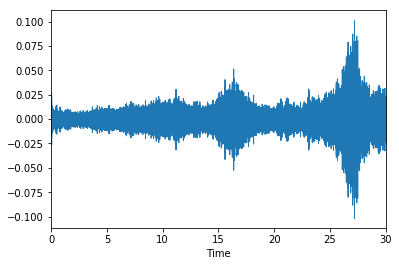

melsp size: (128, 1292)
sampling rate: 22050


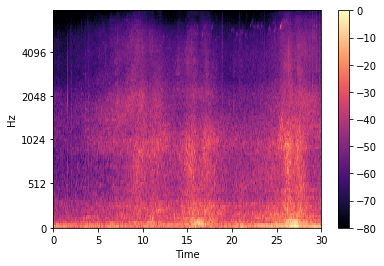

In [9]:
x, fs = load_wave_data(os.path.join(train_dirname, meta_data_train['filename'][0]))

# normal
plot_wave(x)
melsp = calc_melsp(x)
plot_melsp(melsp)
save_melsp_image('melsp.png', melsp, cmap='magma')

ipd.Audio(x, rate=fs)

wave size: (661501,)


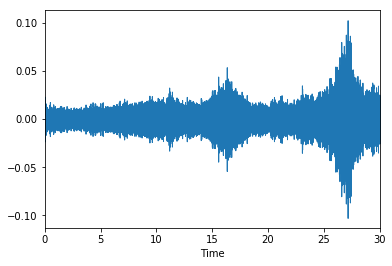

melsp size: (128, 1292)
sampling rate: 22050


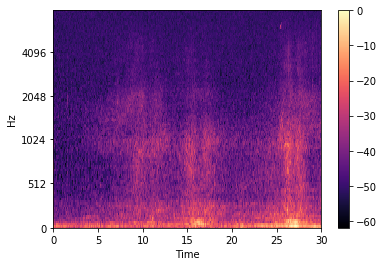

In [10]:
# noise
x_wn = add_white_noise(x)
plot_wave(x_wn)
melsp_wn = calc_melsp(x_wn)
plot_melsp(melsp_wn)
save_melsp_image('melsp_wn.png', melsp_wn, cmap='magma')

ipd.Audio(x_wn, rate=fs)

wave size: (661501,)


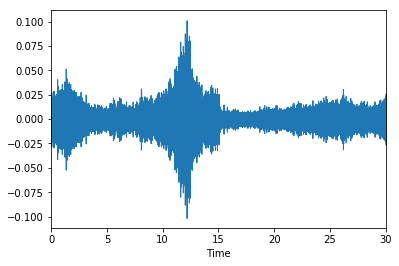

melsp size: (128, 1292)
sampling rate: 22050


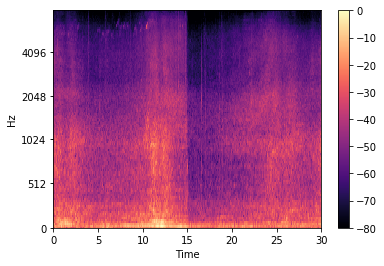

In [11]:
# shift
x_ss = shift_sound(x)
plot_wave(x_ss)
melsp_ss = calc_melsp(x_ss)
plot_melsp(melsp_ss)
save_melsp_image('melsp_ss.png', melsp_ss, cmap='magma')

ipd.Audio(x_ss, rate=fs)

wave size: (661501,)


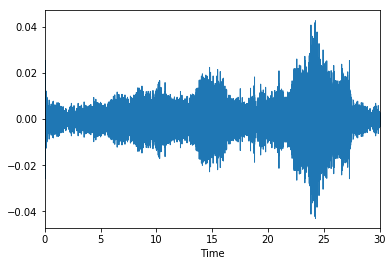

melsp size: (128, 1292)
sampling rate: 22050


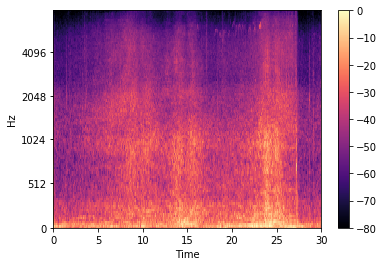

In [27]:
# stretch
x_st = stretch_sound(x)
plot_wave(x_st)
melsp_st = calc_melsp(x_st)
plot_melsp(melsp_st)
save_melsp_image('melsp_st.png', melsp_st, cmap='magma')

ipd.Audio(x_st, rate=fs)

# メルスペクトログラム画像の保存

In [26]:
# save mel-spectrogram as image
def save_melsp_image(file_path, melsp, cmap='magma'):
    # リバース
    melsp = melsp[::-1]
    plt.imsave(file_path, melsp, cmap=cmap)
    

def save_melsp_images(dirname, files, type=None, cmap='magma'):
    if type is None:
        img_dirname = os.path.join(dirname, 'img')
    else:
        img_dirname = os.path.join(dirname, 'img', type)

    os.makedirs(img_dirname, exist_ok=True)

    for file in tqdm(files):
        wav_file_path = os.path.join(dirname, file)
        wav_file_name = os.path.basename(wav_file_path)

        x, fs = load_wave_data(wav_file_path)
        
        if type == 'raw' or type is None:
            pass
        if type == 'wn':
            rate = np.random.randint(0, 50+1) / 1000
            x = add_white_noise(x, rate)
        elif type == 'ss':
            rate = np.random.randint(2, 5+1)
            x = shift_sound(x, rate)
        elif type == 'st':
            rate = np.random.randint(80, 120+1) / 100
            x = stretch_sound(x, rate)
        elif type == 'com':
            rate = np.random.randint(0, 50+1) / 1000
            x = add_white_noise(x, rate)
            if np.random.choice((True, False)):
                rate = np.random.randint(2, 5+1)
                x = shift_sound(x, rate)
            else:
                rate = np.random.randint(80, 120+1) / 100
                x = stretch_sound(x, rate)

        melsp = calc_melsp(x)

        if type is None:
            image_file_path = '{0}/{1}.png'.format(img_dirname, wav_file_name)
        else:
            image_file_path = '{0}/{1}_{2}.png'.format(img_dirname, wav_file_name, type)

        save_melsp_image(image_file_path, melsp, cmap)

In [ ]:
np.random.seed(0)

# 学習データ raw
save_melsp_images(train_dirname, meta_data_train['filename'], type='raw', cmap='hsv')

# 学習データ white noise
save_melsp_images(train_dirname, meta_data_train['filename'], type='wn', cmap='hsv')

# 学習データ shift
save_melsp_images(train_dirname, meta_data_train['filename'], type='ss', cmap='hsv')

# 学習データ stretch
save_melsp_images(train_dirname, meta_data_train['filename'], type='st', cmap='hsv')

# 学習データ composite
save_melsp_images(train_dirname, meta_data_train['filename'], type='com', cmap='hsv')

# 評価データ
save_melsp_images(test_dirname, meta_data_test['filename'], type=None, cmap='hsv')

# 画像を行列に変換して保存

In [14]:
from PIL import Image

def image_to_array(dirname, files, labels, type=None):
    if type is None:
        img_dirname = os.path.join(dirname, 'img')
    else:
        img_dirname = os.path.join(dirname, 'img', type)

    X = []
    Y = []
    
    for file, label in tqdm(zip(files, labels), total=len(files)):
        wav_file_path = os.path.join(dirname, file)
        wav_file_name = os.path.basename(wav_file_path)
        
        if type is None:
            image_file_path = '{0}/{1}.png'.format(img_dirname, wav_file_name)
        else:
            image_file_path = '{0}/{1}_{2}.png'.format(img_dirname, wav_file_name, type)

        img = Image.open(image_file_path)
        img = img.convert("RGB")
        img = img.resize((128, 128), Image.BICUBIC)
        img_array = np.array(img)

        X.append(img_array)
        Y.append(label)
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

def save_np_data(dirname, files, labels, type=None):
    X, Y = image_to_array(dirname, files, labels, type)

    data_dirname = 'data'
    os.makedirs(data_dirname, exist_ok=True)

    if type is None:
        filepath = '{0}/melsp_test.npz'.format(data_dirname)
    else:
        filepath = '{0}/melsp_train_{1}.npz'.format(data_dirname, type)

    np.savez(filepath, x=X, y=Y)

In [21]:
# 学習データ raw
save_np_data(train_dirname, meta_data_train['filename'], meta_data_train['label'], 'raw')

# 学習データ wn
save_np_data(train_dirname, meta_data_train['filename'], meta_data_train['label'], 'wn')

# 学習データ ss
save_np_data(train_dirname, meta_data_train['filename'], meta_data_train['label'], 'ss')

# 学習データ st
save_np_data(train_dirname, meta_data_train['filename'], meta_data_train['label'], 'st')

# 学習データ com
save_np_data(train_dirname, meta_data_train['filename'], meta_data_train['label'], 'com')

# 評価データ
save_np_data(test_dirname, meta_data_test['filename'], meta_data_test['label'])

(1170, 128, 128, 3) (1170,)
audio/a030_60_90.wav


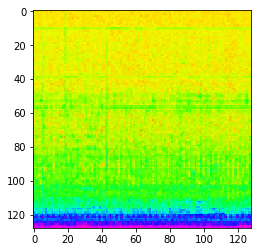

In [17]:
# 読み込みテスト
data_file_path = 'data/melsp_train_com.npz'
data = np.load(data_file_path)
print(data['x'].shape, data['y'].shape)
print(meta_data_train['filename'][123])

plt.imshow(data['x'][123])
plt.show()

In [17]:
meta_dict_train = {}

for i in range(meta_data_train.shape[0]):
    file_name = meta_data_train['filename'][i]
    scene = meta_data_train['scene'][i]
    if scene in meta_dict_train.keys():
        meta_dict_train[scene].append(file_name)
    else:
        meta_dict_train[scene] = [file_name]

pprint(meta_dict_train)


meta_dict_test = {}

for i in range(meta_data_test.shape[0]):
    scene = meta_data_test['scene'][i]
    file_name = meta_data_test['filename'][i]
    if scene in meta_dict_test.keys():
        meta_dict_test[scene].append(file_name)
    else:
        meta_dict_test[scene] = [file_name]

pprint(meta_dict_test)

{'beach': ['audio/a006_0_30.wav',
           'audio/a006_150_180.wav',
           'audio/a006_30_60.wav',
           'audio/a006_60_90.wav',
           'audio/a006_90_120.wav',
           'audio/a014_0_30.wav',
           'audio/a014_120_150.wav',
           'audio/a014_150_180.wav',
           'audio/a014_180_210.wav',
           'audio/a014_30_60.wav',
           'audio/a014_60_90.wav',
           'audio/a014_90_120.wav',
           'audio/a016_0_30.wav',
           'audio/a016_120_150.wav',
           'audio/a016_150_180.wav',
           'audio/a016_180_210.wav',
           'audio/a016_30_60.wav',
           'audio/a016_60_90.wav',
           'audio/a016_90_120.wav',
           'audio/a023_0_30.wav',
           'audio/a023_120_150.wav',
           'audio/a023_150_180.wav',
           'audio/a023_180_210.wav',
           'audio/a023_30_60.wav',
           'audio/a023_60_90.wav',
           'audio/a023_90_120.wav',
           'audio/a026_0_30.wav',
           'audio/a026_120_150.wav',

                     'audio/a130_180_210.wav',
                     'audio/a130_210_240.wav',
                     'audio/a130_30_60.wav',
                     'audio/a130_60_90.wav',
                     'audio/a130_90_120.wav',
                     'audio/b050_0_30.wav',
                     'audio/b050_120_150.wav',
                     'audio/b050_150_180.wav',
                     'audio/b050_180_210.wav',
                     'audio/b050_30_60.wav',
                     'audio/b050_60_90.wav',
                     'audio/b050_90_120.wav',
                     'audio/b056_0_30.wav',
                     'audio/b056_120_150.wav',
                     'audio/b056_150_180.wav',
                     'audio/b056_180_210.wav',
                     'audio/b056_60_90.wav',
                     'audio/b056_90_120.wav'],
 'car': ['audio/a062_0_30.wav',
         'audio/a062_120_150.wav',
         'audio/a062_150_180.wav',
         'audio/a062_30_60.wav',
         'audio/a062_60_90.wav',
    

             'audio/b025_90_120.wav',
             'audio/b034_0_30.wav',
             'audio/b034_120_150.wav',
             'audio/b034_150_180.wav',
             'audio/b034_180_210.wav',
             'audio/b034_210_240.wav',
             'audio/b034_30_60.wav',
             'audio/b034_60_90.wav',
             'audio/b034_90_120.wav',
             'audio/b035_0_30.wav',
             'audio/b035_120_150.wav',
             'audio/b035_150_180.wav',
             'audio/b035_180_210.wav',
             'audio/b035_30_60.wav',
             'audio/b035_60_90.wav',
             'audio/b035_90_120.wav',
             'audio/b036_0_30.wav',
             'audio/b036_150_180.wav',
             'audio/b036_180_210.wav',
             'audio/b036_210_240.wav',
             'audio/b036_60_90.wav',
             'audio/b036_90_120.wav',
             'audio/b037_0_30.wav',
             'audio/b037_120_150.wav',
             'audio/b037_150_180.wav',
             'audio/b037_180_210.wav',
            

           'audio/a144_120_150.wav',
           'audio/a144_180_210.wav',
           'audio/a144_210_240.wav',
           'audio/a144_240_270.wav',
           'audio/a144_270_300.wav',
           'audio/a144_30_60.wav',
           'audio/a144_60_90.wav',
           'audio/a144_90_120.wav',
           'audio/a145_120_150.wav',
           'audio/a145_150_180.wav',
           'audio/a145_180_210.wav',
           'audio/a145_210_240.wav',
           'audio/a145_240_270.wav',
           'audio/a145_30_60.wav',
           'audio/a145_60_90.wav',
           'audio/a145_90_120.wav',
           'audio/b059_135_165.wav',
           'audio/b059_165_195.wav',
           'audio/b059_195_225.wav',
           'audio/b059_30_60.wav',
           'audio/b059_60_90.wav',
           'audio/b059_90_120.wav',
           'audio/b060_0_30.wav',
           'audio/b060_30_60.wav',
           'audio/b060_60_90.wav',
           'audio/b060_90_120.wav',
           'audio/b061_0_30.wav',
           'audio/b061_30_6

          'audio/240.wav',
          'audio/332.wav',
          'audio/69.wav',
          'audio/235.wav',
          'audio/35.wav',
          'audio/44.wav',
          'audio/359.wav',
          'audio/269.wav',
          'audio/195.wav',
          'audio/165.wav',
          'audio/137.wav']}


In [ ]:
import random

random.seed(0)

X = 10
Y = len(meta_dict_train)

plt.figure(figsize=(16,24))

cnt = 1
for key, value in meta_dict_train.items():
    # シーン名
    plt.subplot(Y, X+1, cnt)
    plt.text(0, 0.5, key, fontsize=10)
    plt.axis('off')
    cnt += 1
    
    for file_name in random.choices(value, k=X):
        # メルスペクトログラム計算
        x, fs = load_wave_data(train_dirname + '/' + file_name)
        x = chunked(x, fs*3)[0]
        melsp = calc_melsp(x)
        melsp = np.delete(melsp, [128,129], axis=1)
        # メルスペクトログラム描画
        plt.subplot(Y, X+1, cnt)
        plt.imshow(melsp[::-1], cmap='hsv')
        plt.title(file_name.replace('audio/', ''), fontsize=8)
        plt.axis('off')
        cnt += 1
#plt.show()
plt.savefig('melsps.png')

In [ ]:
def replace_string_list_element(str_list, old, new):
    string = ','.join(str_list)
    string_new = string.replace(old, new)
    str_list_new = string_new.split(',')
    return str_list_new

In [ ]:
N = meta_data_train.shape[0]

# 10分割
name = np.repeat(meta_data_train['filename'], 10)
index = np.array(list(range(10))*N, dtype=str)
print(name.shape, index.shape)

scene = np.repeat(meta_data_train[1], 10)

# 5倍に水増し
pass

meta_data_train_ex = pd.DataFrame({ 'name' : name.astype(object) + '_' + index.astype(object) + '.png',
                                    'scene' : scene })
meta_data_train_ex.head(50)

In [ ]:
N = meta_data_test.shape[0]

# 10分割
name = np.repeat(meta_data_test['filrname'], 10)
index = np.array(list(range(10))*N, dtype=str)
print(name.shape, index.shape)

scene = np.repeat(meta_data_test[1], 10)

# 5倍に水増し
pass

meta_data_test_ex = pd.DataFrame({ 'name' : name.astype(object) + '_' + index.astype(object) + '.png',
                                   'scene' : scene })
meta_data_test_ex.head(50)